In [1]:
from utils.CoopEnv import CoopEnv
from utils.IACagent import Agent
from utils.ChaoticAgent import ChaoticAgent

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set constant hyperparameters
n_learner = 10
n_simple = 5
n = n_learner+n_simple

num_of_tasks  = 8
num_of_sims = 1
step_limit = 20000

In [4]:
lower_bound = 0
upper_bound = 2.00
comm_array = np.linspace(lower_bound, upper_bound, 21)

comm_space = len(comm_array)

In [5]:
env = CoopEnv(n=n, num_of_tasks=num_of_tasks)
alr = 3e-4
vlr = 6e-4
ecoef = 0.08

In [6]:
steps_to_complete = np.zeros((num_of_sims, step_limit))
comm_rec_actions = np.zeros((num_of_sims, step_limit, env.n))
move_rec_actions = np.zeros((num_of_sims, step_limit, env.n))
rec_rewards = np.zeros((num_of_sims, step_limit, env.n))

In [7]:
def main():

    for s in range(num_of_sims):

        print("----------------------------------")
        print(f"Starting training simulation {s}:")
        print("----------------------------------")

        # reinitialise agent list each sim
        # reset the environment
        agentlist_learner = {i: Agent(alr=alr, vlr=vlr, ecoef=ecoef, num_arms=comm_space) for i in range(n_learner)}
        agentlist_simple = {j: ChaoticAgent(num_arms=comm_space) for j in range(n_simple)}

        observations = env.reset(n=n, num_of_tasks =num_of_tasks)

        # begin training loop

        t = 0
        while t < step_limit:
            print(t, end='\r')

            # collect move action for each agent
            move_action_learner = np.array([agentlist_learner[i].choose_action_move(observations[i]) for i in range(n_learner)])
            move_action_simple = np.array([agentlist_simple[j].choose_action_move() for j in range(n_simple)])
            move_action = np.concatenate((move_action_learner, move_action_simple))

            # env step 1
            next_observations, context = env.step1(move_action)

            # collect comm action for each agent
            comm_action_ind_learner = np.array([agentlist_learner[i].select_arm() for i in range(n_learner)])
            comm_action_ind_simple = np.array([agentlist_simple[j].select_arm() for j in range(n_simple)])
            comm_action_ind = np.concatenate((comm_action_ind_learner, comm_action_ind_simple))
            comm_action = comm_array[comm_action_ind]

            # env step 2
            rewards = env.step2(comm_action) # env.step

            # record stats
            comm_rec_actions[s, t, :] = comm_action  # output from actor (comm head)
            move_rec_actions[s, t, :] = move_action

            for i in range(n_learner): # train each agent
                action = np.array([move_action[i], comm_action_ind[i]])
                agentlist_learner[i].train(observations[i], action[0], rewards[i], next_observations[i])
                agentlist_learner[i].update_comm(action[1], rewards[i])

            # advance state
            observations = next_observations
            # record average system reward score
            steps_to_complete[s, t] = sum(rewards)/env.n
            rec_rewards[s, t, :] = rewards


            # increment timestep and loop
            t +=1


In [8]:
if __name__ == "__main__":

    #cProfile.run('main()')
    main()


----------------------------------
Starting training simulation 0:
----------------------------------
[0 2 0 1 1 2 2 0 1 1]
[2 1 0 1 0]
[0 2 0 1 1 2 2 0 1 1 2 1 0 1 0]
[ 0 13  3  1  2 19  0 20  8 14]
[ 0 15  5 20  3]
[ 0 13  3  1  2 19  0 20  8 14  0 15  5 20  3]
[2 1 2 1 2 0 1 1 0 1]
[0 2 2 0 0]
[2 1 2 1 2 0 1 1 0 1 0 2 2 0 0]
[ 6  0  2  5 19  7 14  0  9  9]
[11  3  2  5  2]
[ 6  0  2  5 19  7 14  0  9  9 11  3  2  5  2]
[2 1 2 2 2 0 0 0 2 0]
[1 1 2 0 0]
[2 1 2 2 2 0 0 0 2 0 1 1 2 0 0]
[ 4  6  9  4  9 11  1  9  0  4]
[ 7 16 15  9 18]
[ 4  6  9  4  9 11  1  9  0  4  7 16 15  9 18]
[0 0 2 1 2 0 2 0 2 2]
[1 0 2 2 1]
[0 0 2 1 2 0 2 0 2 2 1 0 2 2 1]
[20  1  5  0 20  4 11 11 12  8]
[ 1  8  2  6 15]
[20  1  5  0 20  4 11 11 12  8  1  8  2  6 15]
[0 2 0 1 2 0 0 1 0 1]
[2 2 2 1 1]
[0 2 0 1 2 0 0 1 0 1 2 2 2 1 1]
[ 6 14  4 14 12 14  7 14  8 10]
[ 9  4 13 17  3]
[ 6 14  4 14 12 14  7 14  8 10  9  4 13 17  3]
[0 1 1 2 0 1 0 1 0 2]
[1 1 2 0 0]
[0 1 1 2 0 1 0 1 0 2 1 1 2 0 0]
[ 9  3 15  6 14  7  9 

IndexError: index 21 is out of bounds for axis 0 with size 21

In [ ]:
# save reward and actions
converged_structure = np.zeros((num_of_tasks, env.n))
task = 0
for C in env.CS:
    indices = [int(a)-1 for a in list(C)]
    converged_structure[task, indices] = 1
    task+=1

np.save(f'n{n}t{num_of_tasks}_cum_rew', steps_to_complete)
np.save(f'n{n}t{num_of_tasks}_rewards', rec_rewards)
np.save(f'n{n}t{num_of_tasks}_actions', comm_rec_actions)
np.save(f'n{n}t{num_of_tasks}_cstruct.npy', converged_structure)

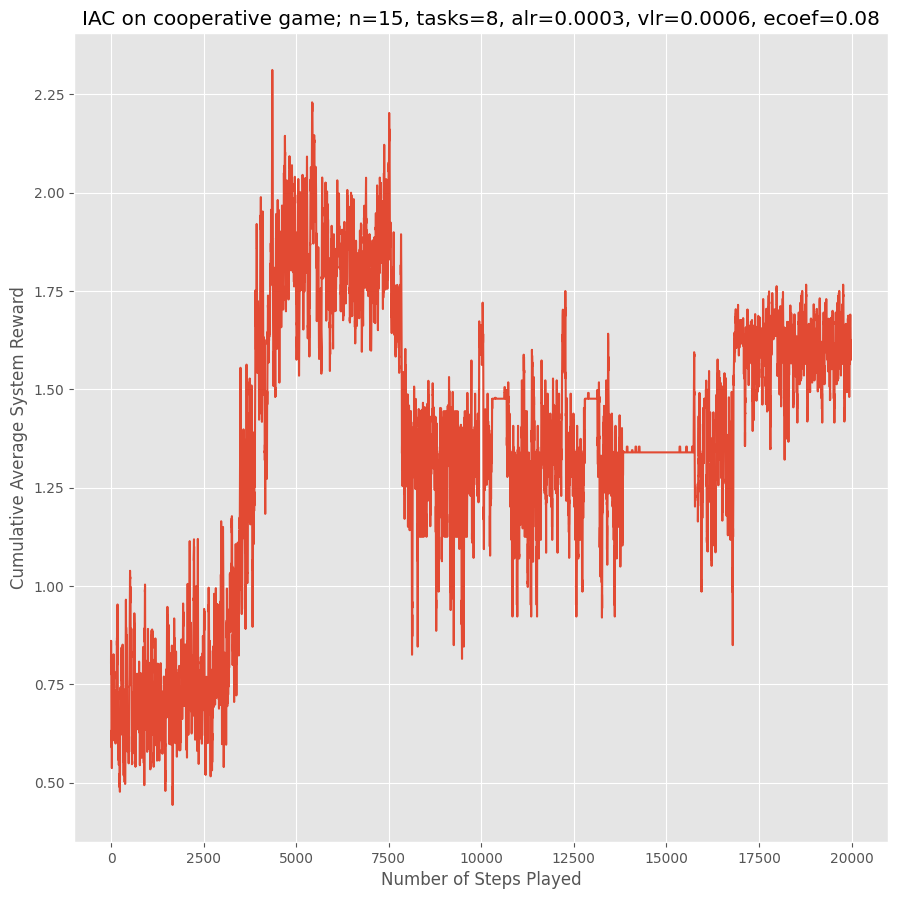

In [ ]:
plt.style.use('ggplot')
b = np.mean(steps_to_complete, axis=0)
s_dev = np.std(steps_to_complete, axis=0)

def moving_average(arr, window_size):
    moving_averages = []
    for i in range(len(arr) - window_size + 1):
        window = arr[i:i + window_size]
        average = sum(window) / window_size
        moving_averages.append(average)
    return moving_averages

plt.xlabel('Number of Steps Played')
plt.ylabel('Cumulative Average System Reward')
plt.title(f'IAC on cooperative game; n={n}, tasks={num_of_tasks}, alr={alr}, vlr={vlr}, ecoef={ecoef}')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.plot(moving_average(b,20))

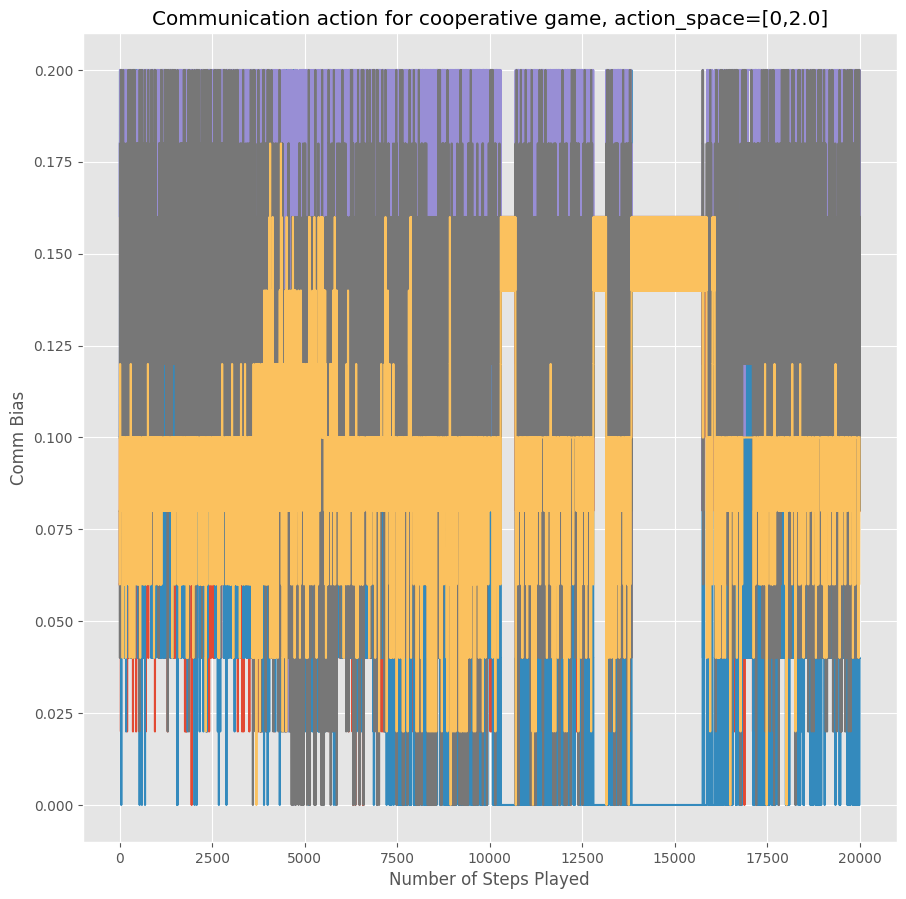

In [ ]:
# See communication action averaged across sims

plt.xlabel('Number of Steps Played')
plt.ylabel('Comm Bias')
plt.title(f'Communication action for cooperative game, action_space=[{lower_bound},{upper_bound}]')

for j in range(n_learner,n):
    col  = np.mean(comm_rec_actions[:,:,j],axis=0)
    plt.plot(moving_average(col, 5))

fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

[{'1', '5', '9', '4', '3', '2', '6', '10', '8'}, set(), {'14'}, {'12', '7'}, set(), {'13', '15'}, {'11'}, set()]


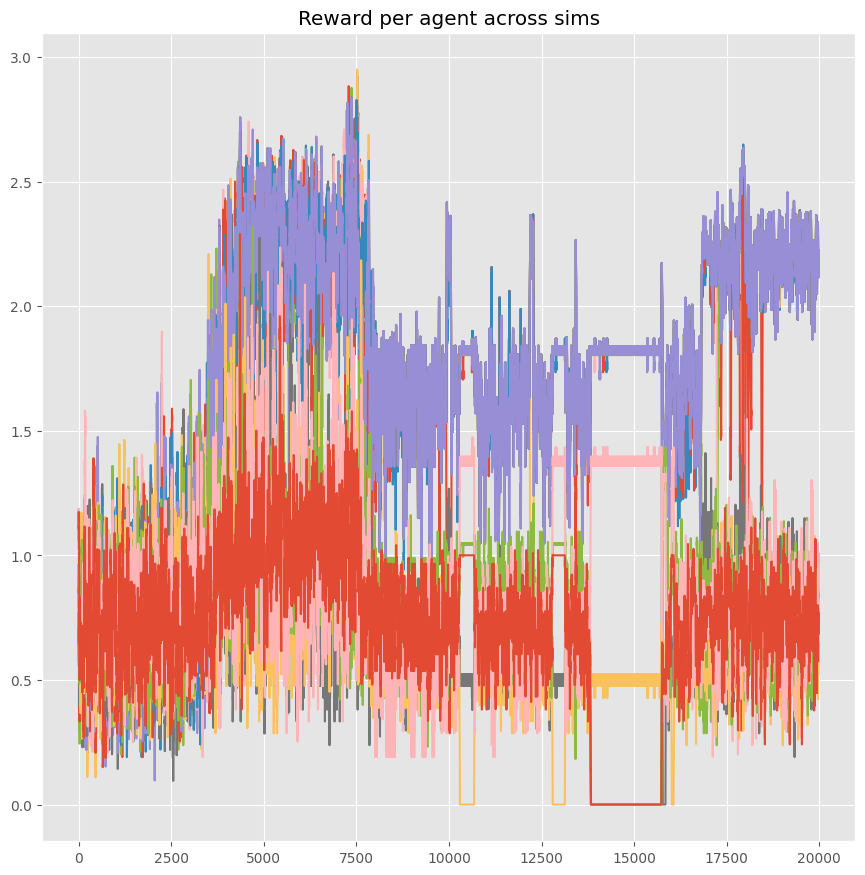

In [ ]:
# see agent reward breakdown across sims

print(env.CS)
for j in range(env.n):
    col  = np.mean(rec_rewards[:,:,j],axis=0)
    plt.plot(moving_average(col, 21))

fig = plt.gcf()
plt.title('Reward per agent across sims')
fig.set_size_inches(10.5, 10.5)

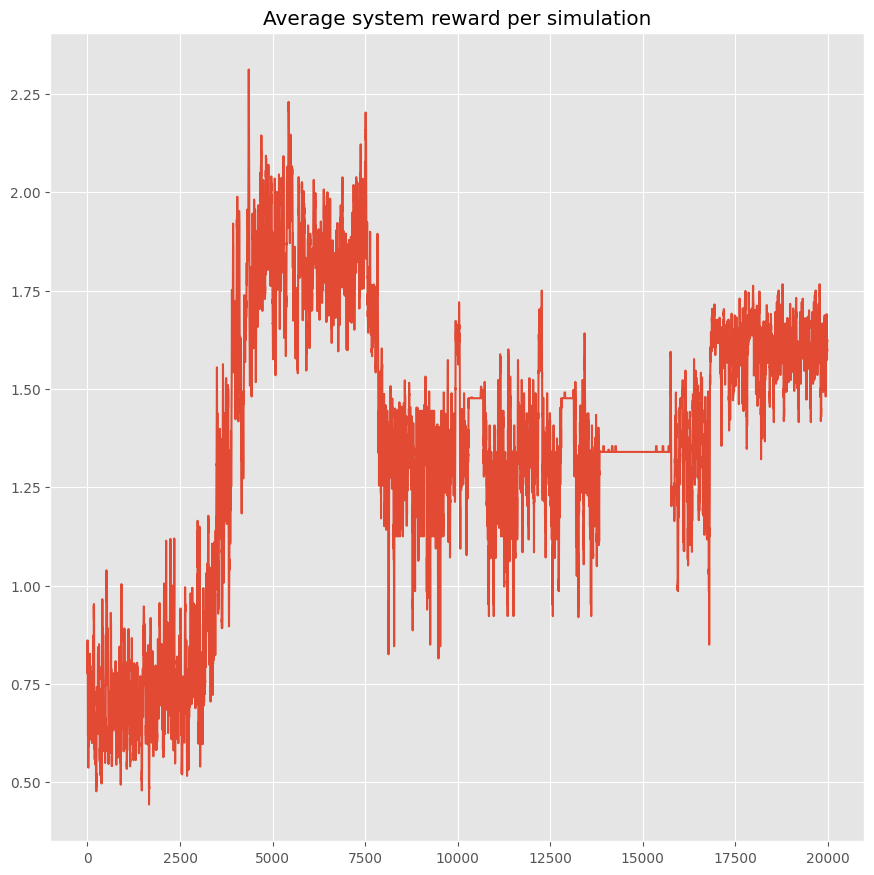

In [ ]:
# See average reward breakdown for each sim

for i in range(num_of_sims):
    plt.plot(moving_average(steps_to_complete[i,:],20))

plt.title('Average system reward per simulation')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)